<a href="https://colab.research.google.com/github/NimishaX0/Credit-Score-Model-for-DeFi-/blob/main/ZERUassignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
import pandas as pd
import json
from datetime import datetime
from sklearn.preprocessing import StandardScaler

In [132]:
# Decimals for token normalization
TOKEN_DECIMALS = {'USDC': 6, 'DAI': 18, 'WETH': 18, 'WBTC': 8, 'USDT': 6}

with open('user-wallet-transactions.json') as f:
    data = json.load(f)

In [133]:
df=pd.DataFrame(data)
df.head()

,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


In [134]:
df.shape

(100000, 13)

In [135]:
# Extract & clean
df['wallet'] = df['userWallet']
df['time'] = pd.to_datetime(df['timestamp'], unit='s')
df['action'] = df['action'].str.lower()

def get_usd_amount(row):
    try:
        decimals = TOKEN_DECIMALS.get(row['actionData'].get('assetSymbol', 'USDC'), 18)
        raw_amount = int(row['actionData']['amount'])
        price = float(row['actionData'].get('assetPriceUSD', 1))
        return (raw_amount / (10 ** decimals)) * price
    except:
        return 0.0

In [136]:
df['amount_usd'] = df.apply(get_usd_amount, axis=1)
df['asset'] = df['actionData'].apply(lambda x: x.get('assetSymbol', 'UNKNOWN'))


df = df[['wallet', 'time', 'action', 'amount_usd', 'asset']]

In [ ]:
df.head()

,wallet,time,action,amount_usd,asset
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,2021-08-17 05:29:26,deposit,1987.663655,USDC
1,0x000000000051d07a4fb3bd10121a343d85818da6,2021-05-20 15:36:53,deposit,285.694480,WMATIC
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-24 09:28:33,deposit,0.000922,WMATIC
3,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-31 23:15:18,deposit,0.004230,WMATIC
4,0x0000000000e189dd664b9ab08a33c4839953852c,2021-04-19 15:25:07,redeemunderlying,0.502616,USDC


In [137]:
def extract_features(group):
    group = group.copy()
    deposits = group[group['action'] == 'deposit']['amount_usd'].sum()
    borrows = group[group['action'] == 'borrow']['amount_usd'].sum()
    repays = group[group['action'] == 'repay']['amount_usd'].sum()
    redeems = group[group['action'] == 'redeemunderlying']['amount_usd'].sum()
    liquidations = group[group['action'] == 'liquidationcall'].shape[0]

    return pd.Series({
        'n_total_txn': len(group),
        'n_deposit': (group['action'] == 'deposit').sum(),
        'n_borrow': (group['action'] == 'borrow').sum(),
        'n_repay': (group['action'] == 'repay').sum(),
        'n_redeem': (group['action'] == 'redeemunderlying').sum(),
        'n_liquidation': liquidations,
        'total_deposit_usd': deposits,
        'total_borrow_usd': borrows,
        'total_repay_usd': repays,
        'unique_assets': group['asset'].nunique(),
        'active_days': group['time'].dt.date.nunique(),
        'first_txn': group['time'].min(),
        'last_txn': group['time'].max()
    })

agg = df.groupby('wallet').apply(extract_features)

/tmp/ipython-input-137-2656599678.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = df.groupby('wallet').apply(extract_features)


In [138]:
# removing all wallets with no borrowed usd from agg. we are assuming that credit score depends especially on a wallet's
# borrowing and repaying habits and thus for wallets with no borrow should be graded using otherless imprtant features (liquidation ratio, average score value assignment etc)

agg_filtered = agg[agg['total_borrow_usd'] > 0].copy()

In [139]:
agg.head()

,n_total_txn,n_deposit,n_borrow,n_repay,n_redeem,n_liquidation,total_deposit_usd,total_borrow_usd,total_repay_usd,unique_assets,active_days,first_txn,last_txn
wallet,,,,,,,,,,,,,
0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,0,0,0,0,1987.663655,0.000000,0.000000,1,1,2021-08-17 05:29:26,2021-08-17 05:29:26
0x000000000051d07a4fb3bd10121a343d85818da6,1,1,0,0,0,0,285.694480,0.000000,0.000000,1,1,2021-05-20 15:36:53,2021-05-20 15:36:53
0x000000000096026fb41fc39f9875d164bd82e2dc,2,2,0,0,0,0,0.005152,0.000000,0.000000,1,2,2021-07-24 09:28:33,2021-07-31 23:15:18
0x0000000000e189dd664b9ab08a33c4839953852c,17,0,0,0,17,0,0.000000,0.000000,0.000000,4,8,2021-04-19 15:23:17,2021-08-26 23:15:16
0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,250,15,4,130,0,925490.696960,130355.754756,70150.263791,6,104,2021-04-21 21:28:30,2021-09-01 18:15:24


In [140]:
agg.loc[  '0x060bb7f9d479437099cd521df4f5051a247ab3ae']

,0x060bb7f9d479437099cd521df4f5051a247ab3ae
n_total_txn,2
n_deposit,0
n_borrow,0
n_repay,0
n_redeem,2
n_liquidation,0
total_deposit_usd,0.0
total_borrow_usd,0.0
total_repay_usd,0.0
unique_assets,2


In [141]:
# Derived features
agg['borrow_to_deposit'] = agg['total_borrow_usd']/(agg['total_deposit_usd'] +1e-6)
agg['repay_to_borrow'] = agg['total_repay_usd'] / (agg['total_borrow_usd']+1e-6)
agg['txns_per_day'] = agg['n_total_txn'] / agg['active_days']
agg['liquidation_ratio'] = agg['n_liquidation'] / (agg['n_total_txn'] + 1e-6)
agg['days_active_span'] = (agg['last_txn'] - agg['first_txn']).dt.days + 1

In [142]:
agg.tail()

,n_total_txn,n_deposit,n_borrow,n_repay,n_redeem,n_liquidation,total_deposit_usd,total_borrow_usd,total_repay_usd,unique_assets,active_days,first_txn,last_txn,borrow_to_deposit,repay_to_borrow,txns_per_day,liquidation_ratio,days_active_span
wallet,,,,,,,,,,,,,,,,,,
0x06185db89f5c8ef5e5a0abc95c5cb69b54c33f30,1,1,0,0,0,0,0.000099,0.000000e+00,0.000000,1,1,2021-07-12 22:31:43,2021-07-12 22:31:43,0.000000,0.000000,1.000000,0.0,1
0x06189341e523a52ae10c4bd4a7774371fac1b249,7,4,1,0,2,0,22.642876,2.330736e+00,0.000000,3,1,2021-05-30 07:22:19,2021-05-30 14:02:49,0.102935,0.000000,7.000000,0.0,1
0x0618c450370822c5cb25ec143a3008230d8e2c12,5,1,0,0,4,0,35309.766244,0.000000e+00,0.000000,4,1,2021-05-20 03:52:58,2021-05-20 04:08:15,0.000000,0.000000,5.000000,0.0,1
0x0618e615c8c9b5efc8c8eadc68be7182bdc455e2,22,13,2,2,5,0,6813.240971,1.202218e+03,199.896161,7,11,2021-06-10 22:09:52,2021-07-11 23:44:47,0.176453,0.166273,2.000000,0.0,32
0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,183,53,48,36,46,0,512362.172917,1.040512e+06,760247.360881,7,37,2021-04-16 19:02:01,2021-06-15 08:26:17,2.030814,0.730647,4.945946,0.0,60


In [143]:
# Clean
agg.fillna(0, inplace=True)
X = agg.drop(columns=['first_txn', 'last_txn'])


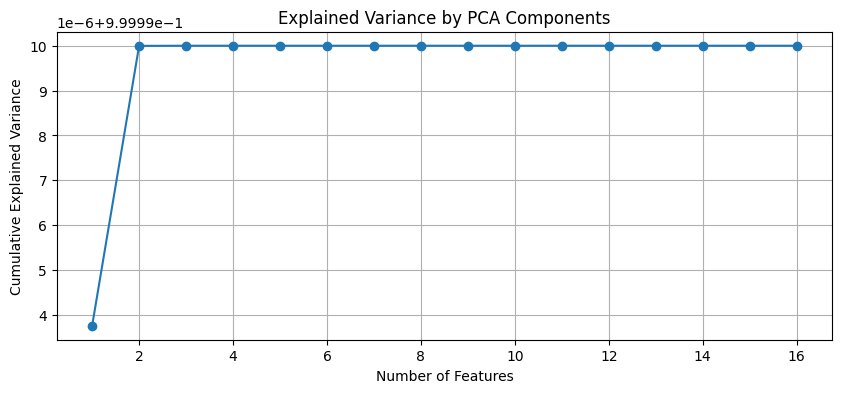

In [144]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(X)

# Plot explained variance
plt.figure(figsize=(10,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title("Explained Variance by PCA Components")
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()


<Axes: title={'center': 'Feature Importances from RandomForest (KMeans clusters as targets)'}>

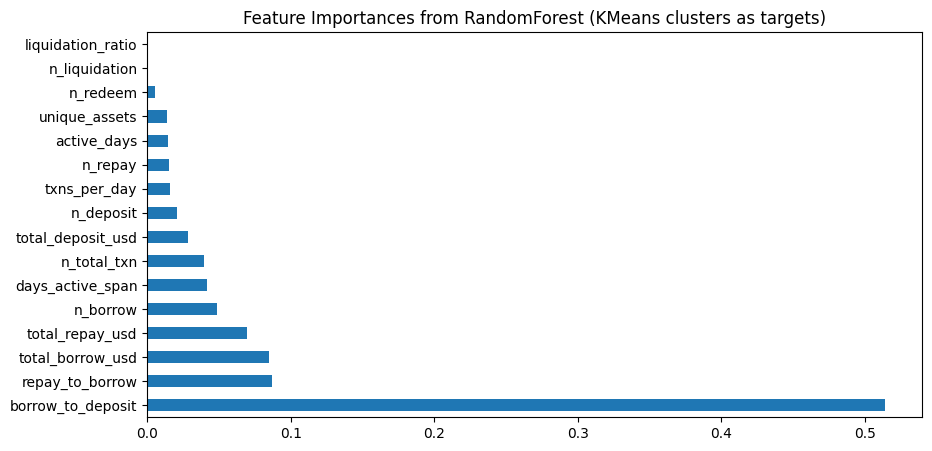

In [145]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Step 1: Cluster using KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
cluster = kmeans.fit_predict(X)

# Step 2: Train a classifier to predict clusters
clf = RandomForestClassifier()
clf.fit(X, cluster)

# Step 3: Get feature importances
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(10,5), title='Feature Importances from RandomForest (KMeans clusters as targets)')


In [146]:
X.loc[ '0x060bb7f9d479437099cd521df4f5051a247ab3ae']

,0x060bb7f9d479437099cd521df4f5051a247ab3ae
n_total_txn,2.0
n_deposit,0.0
n_borrow,0.0
n_repay,0.0
n_redeem,2.0
n_liquidation,0.0
total_deposit_usd,0.0
total_borrow_usd,0.0
total_repay_usd,0.0
unique_assets,2.0


In [111]:
X.loc[ '0x01615d8d53eb9aafcda15853286fdf8259368a68']

,0x01615d8d53eb9aafcda15853286fdf8259368a68
n_total_txn,2.000000e+00
n_deposit,0.000000e+00
n_borrow,0.000000e+00
n_repay,1.000000e+00
n_redeem,1.000000e+00
n_liquidation,0.000000e+00
total_deposit_usd,0.000000e+00
total_borrow_usd,0.000000e+00
total_repay_usd,7.792635e+03
unique_assets,2.000000e+00


In [110]:
X.loc['0x00000000001accfa9cef68cf5371a23025b6d4b6']

,0x00000000001accfa9cef68cf5371a23025b6d4b6
n_total_txn,1.000000
n_deposit,1.000000
n_borrow,0.000000
n_repay,0.000000
n_redeem,0.000000
n_liquidation,0.000000
total_deposit_usd,1987.663655
total_borrow_usd,0.000000
total_repay_usd,0.000000
unique_assets,1.000000


In [129]:
X.loc[ '0x003be39433bde975b12411fbc3025d49d813a84f']

,0x003be39433bde975b12411fbc3025d49d813a84f
n_total_txn,4.000000
n_deposit,0.000000
n_borrow,1.000000
n_repay,0.000000
n_redeem,0.000000
n_liquidation,3.000000
total_deposit_usd,0.000000
total_borrow_usd,0.732132
total_repay_usd,0.000000
unique_assets,2.000000


In [112]:
X.loc['0x003be39433bde975b12411fbc3025d49d813a84f']

,0x003be39433bde975b12411fbc3025d49d813a84f
n_total_txn,4.000000
n_deposit,0.000000
n_borrow,1.000000
n_repay,0.000000
n_redeem,0.000000
n_liquidation,3.000000
total_deposit_usd,0.000000
total_borrow_usd,0.732132
total_repay_usd,0.000000
unique_assets,2.000000


In [113]:
X.loc['0x03f16156ae491cd53474aa12d8c4d0a3ef906839']

,0x03f16156ae491cd53474aa12d8c4d0a3ef906839
n_total_txn,3.000000
n_deposit,1.000000
n_borrow,0.000000
n_repay,0.000000
n_redeem,2.000000
n_liquidation,0.000000
total_deposit_usd,4926.978771
total_borrow_usd,0.000000
total_repay_usd,0.000000
unique_assets,2.000000


In [147]:
from sklearn.cluster import KMeans
import numpy as np

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Clustering into 5 bhvr groups
kmeans = KMeans(n_clusters=100, random_state=42)
X['cluster'] = kmeans.fit_predict(X_scaled)







In [155]:
# Analyzing & map clusters to scores
cluster_summary = X.groupby('cluster').agg({
    'repay_to_borrow': 'mean',
  'liquidation_ratio': 'mean' # Include liquidation_ratio in the aggregation as it is like a credit default history n more liq.ratio -> less responsible-> low credit score
}).reset_index()

cluster_summary['score_index'] = ( cluster_summary['repay_to_borrow'] -cluster_summary['liquidation_ratio'])

cluster_summary = cluster_summary.sort_values('score_index', ascending=False)
cluster_summary['credit_score'] = np.linspace(1000, 0, len(cluster_summary)).astype(int)

# Map back
score_map = cluster_summary.set_index('cluster')['credit_score'].to_dict()
X['credit_score'] = X['cluster'].map(score_map)

In [156]:
X.describe()


,n_total_txn,n_deposit,n_borrow,n_repay,n_redeem,n_liquidation,total_deposit_usd,total_borrow_usd,total_repay_usd,unique_assets,active_days,borrow_to_deposit,repay_to_borrow,txns_per_day,liquidation_ratio,days_active_span,cluster,credit_score
count,3497.000000,3497.000000,3497.000000,3497.000000,3497.000000,3497.000000,3.497000e+03,3.497000e+03,3.497000e+03,3497.000000,3497.000000,3.497000e+03,3.497000e+03,3497.000000,3497.000000,3497.000000,3497.000000,3497.000000
mean,28.595939,10.811553,4.885902,3.589648,9.237918,0.070918,1.754967e+05,1.175732e+05,8.891131e+04,2.452960,6.563912,1.425938e+09,2.228613e+06,2.618057,0.003592,22.593080,32.308264,302.640549
std,250.732075,29.868997,15.133573,13.374770,242.518307,0.692889,2.179518e+06,1.479900e+06,1.187504e+06,1.960604,12.529142,5.276915e+10,1.317760e+08,4.751864,0.032567,33.174518,29.856003,294.371598
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.061817e+00,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,1.000000,10.000000,60.000000
50%,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,4.803163e+01,0.000000e+00,0.000000e+00,2.000000,2.000000,0.000000e+00,0.000000e+00,1.666667,0.000000,3.000000,10.000000,161.000000
75%,16.000000,6.000000,3.000000,2.000000,3.000000,0.000000,4.056299e+03,8.997755e+02,4.575458e+02,3.000000,5.000000,4.083530e-01,6.584248e-01,3.000000,0.000000,33.000000,60.000000,525.000000
max,14265.000000,511.000000,200.000000,291.000000,14265.000000,26.000000,6.167728e+07,4.703976e+07,4.690745e+07,9.000000,112.000000,2.914553e+12,7.792635e+09,216.136364,0.750000,154.000000,99.000000,1000.000000


In [157]:
X

,n_total_txn,n_deposit,n_borrow,n_repay,n_redeem,n_liquidation,total_deposit_usd,total_borrow_usd,total_repay_usd,unique_assets,active_days,borrow_to_deposit,repay_to_borrow,txns_per_day,liquidation_ratio,days_active_span,cluster,credit_score,score_range
wallet,,,,,,,,,,,,,,,,,,,
0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,0,0,0,0,1987.663655,0.000000e+00,0.000000,1,1,0.000000,0.000000,1.000000,0.0,1,10,60,100-199
0x000000000051d07a4fb3bd10121a343d85818da6,1,1,0,0,0,0,285.694480,0.000000e+00,0.000000,1,1,0.000000,0.000000,1.000000,0.0,1,10,60,100-199
0x000000000096026fb41fc39f9875d164bd82e2dc,2,2,0,0,0,0,0.005152,0.000000e+00,0.000000,1,2,0.000000,0.000000,1.000000,0.0,8,10,60,100-199
0x0000000000e189dd664b9ab08a33c4839953852c,17,0,0,0,17,0,0.000000,0.000000e+00,0.000000,4,8,0.000000,0.000000,2.125000,0.0,130,67,151,200-299
0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,250,15,4,130,0,925490.696960,1.303558e+05,70150.263791,6,104,0.140850,0.538145,3.836538,0.0,133,23,252,300-399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x06185db89f5c8ef5e5a0abc95c5cb69b54c33f30,1,1,0,0,0,0,0.000099,0.000000e+00,0.000000,1,1,0.000000,0.000000,1.000000,0.0,1,10,60,100-199
0x06189341e523a52ae10c4bd4a7774371fac1b249,7,4,1,0,2,0,22.642876,2.330736e+00,0.000000,3,1,0.102935,0.000000,7.000000,0.0,1,31,595,600-699
0x0618c450370822c5cb25ec143a3008230d8e2c12,5,1,0,0,4,0,35309.766244,0.000000e+00,0.000000,4,1,0.000000,0.000000,5.000000,0.0,1,31,595,600-699


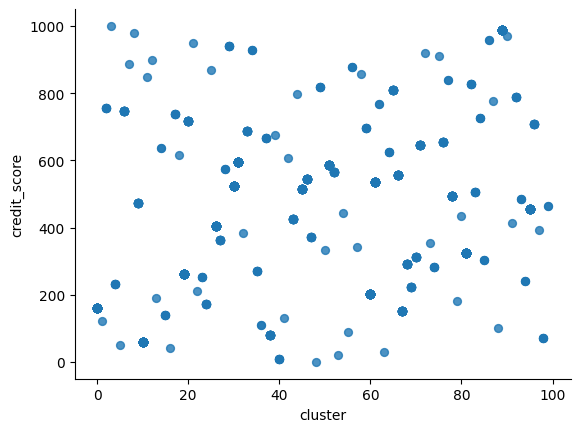

In [158]:
from matplotlib import pyplot as plt
X.plot(kind='scatter', x='cluster', y='credit_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [159]:
X[['credit_score']].reset_index().to_json('wallet_scores.json', orient='records', indent=2)


In [163]:
X.sort_values(by='credit_score')

,n_total_txn,n_deposit,n_borrow,n_repay,n_redeem,n_liquidation,total_deposit_usd,total_borrow_usd,total_repay_usd,unique_assets,active_days,borrow_to_deposit,repay_to_borrow,txns_per_day,liquidation_ratio,days_active_span,cluster,credit_score,score_range
wallet,,,,,,,,,,,,,,,,,,,
0x003be39433bde975b12411fbc3025d49d813a84f,4,0,1,0,0,3,0.000000,0.732132,0.00000,2,4,732131.713067,0.000000e+00,1.00,0.750000,33,48,0,100-199
0x03f90f638fc2c73e43008e66e11e554a8de746ae,3,1,1,0,0,1,296.150453,60.108315,0.00000,3,2,0.202965,0.000000e+00,1.50,0.333333,63,40,10,100-199
0x03478c0564936f7a51138d28d1cdce99855c2b7f,5,2,1,0,0,2,5312.095069,3510.812062,0.00000,3,4,0.660909,0.000000e+00,1.25,0.400000,8,40,10,100-199
0x038a122489ebd2bf9968e02d1203258b49e4832e,6,2,2,0,0,2,321.808573,128.755816,0.00000,3,2,0.400101,0.000000e+00,3.00,0.333333,18,40,10,100-199
0x009b56330ae5ec5042b9ca46ddb3043cc0d006f3,3,1,1,0,0,1,402.967000,94.499791,0.00000,3,2,0.234510,0.000000e+00,1.50,0.333333,8,40,10,100-199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x06127311a4fb86ffdce6f781d7db183e9c2a3d34,2,1,1,0,0,0,0.064892,0.004969,0.00000,2,1,0.076576,0.000000e+00,2.00,0.000000,1,89,989,900-999
0x000f3b3cba440b4bd611d2ac4b6271400fb1e4e1,2,1,0,0,1,0,102.377389,0.000000,0.00000,2,2,0.000000,0.000000e+00,1.00,0.000000,16,89,989,900-999
0x060cd95870d75c91168f12a451d71c3231a79c66,2,1,1,0,0,0,0.015854,0.002251,0.00000,2,1,0.141969,0.000000e+00,2.00,0.000000,1,89,989,900-999


In [168]:
# Define score ranges
score_bins = range(0, 1101, 100) # Bins from 0 to 1100 with steps of 100
score_labels = [f'{i}-{i+99}' for i in score_bins[:-1]]

# Categorize wallets into score ranges
X['score_range'] = pd.cut(X['credit_score'], bins=score_bins, labels=score_labels, right=False, include_lowest=True)

# Count wallets in each range
score_distribution = X['score_range'].value_counts().sort_index()

print("Credit Score Distribution:")
print(score_distribution)

Credit Score Distribution:
score_range
0-99         1621
100-199       215
200-299       249
300-399       177
400-499       202
500-599       561
600-699        79
700-799        82
800-899        41
900-999       269
1000-1099       1
Name: count, dtype: int64



Behavior of Wallets in the Lower Credit Score Range:
        n_total_txn    n_deposit     n_borrow      n_repay      n_redeem  \
count   1594.000000  1594.000000  1594.000000  1594.000000   1594.000000   
mean      11.193852     1.202008     0.096612     0.007528      9.876412   
std      358.557143     0.698377     0.360583     0.093444    358.591673   
min        1.000000     0.000000     0.000000     0.000000      0.000000   
25%        1.000000     1.000000     0.000000     0.000000      0.000000   
50%        1.000000     1.000000     0.000000     0.000000      0.000000   
75%        2.000000     1.000000     0.000000     0.000000      0.000000   
max    14265.000000     9.000000     8.000000     2.000000  14265.000000   

       n_liquidation  total_deposit_usd  total_borrow_usd  total_repay_usd  \
count    1594.000000       1.594000e+03       1594.000000      1594.000000   
mean        0.011292       1.220860e+04        210.459653       247.934027   
std         0.209319       

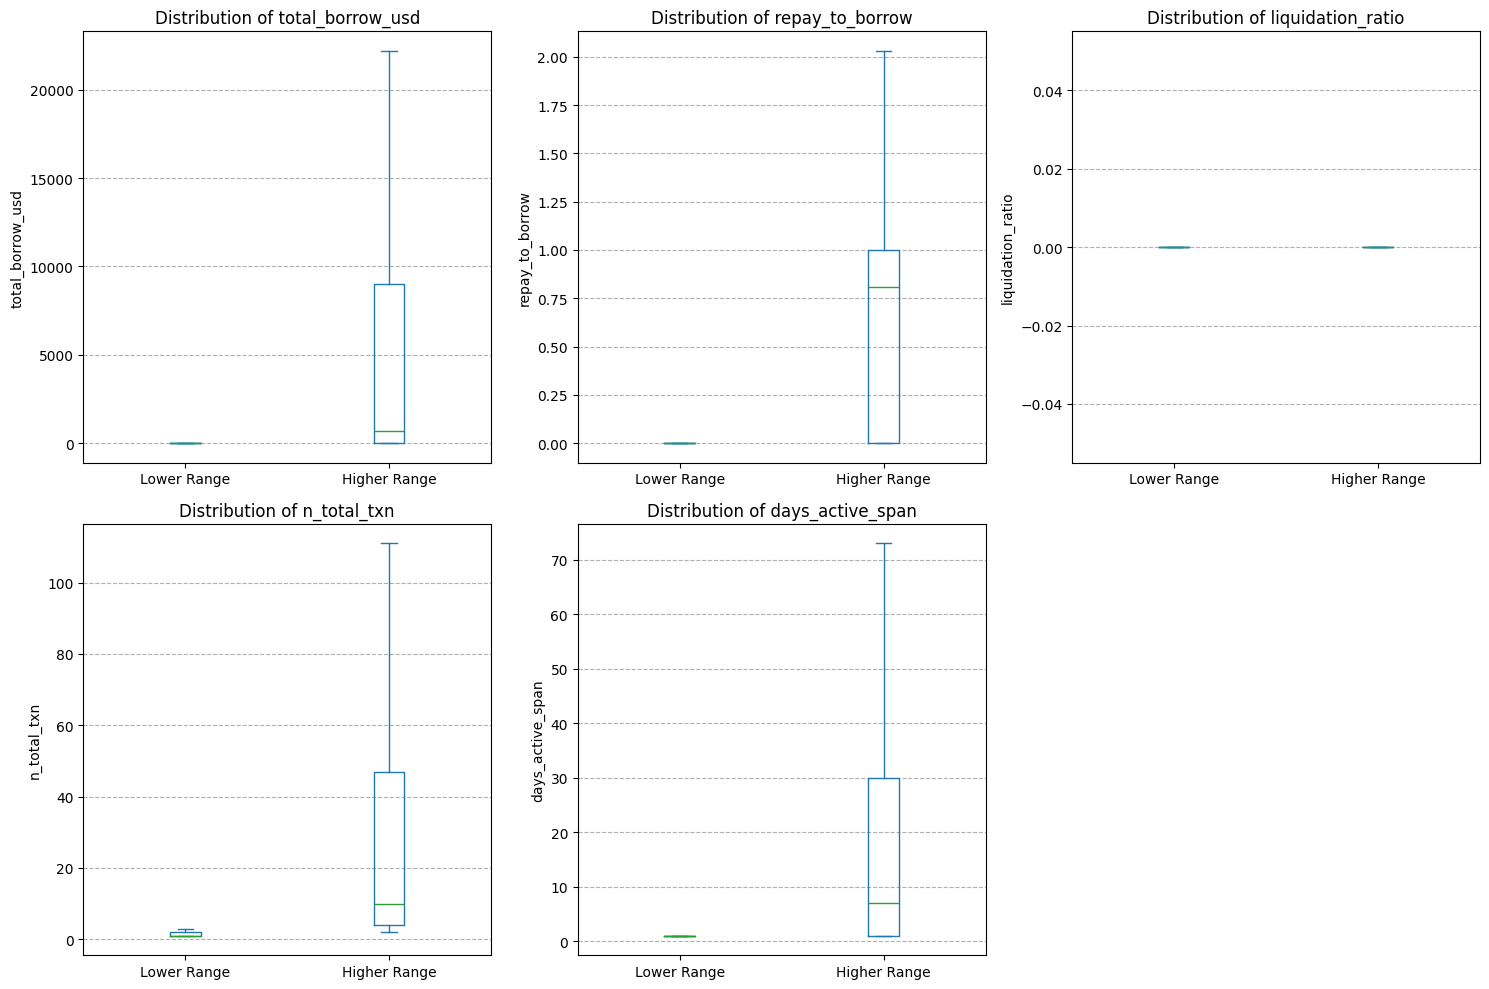

In [169]:
# Separate wallets into lower and higher ranges based on credit score
lower_range_wallets = X[X['credit_score'] <= X['credit_score'].quantile(0.25)] # lower 25%
higher_range_wallets = X[X['credit_score'] >= X['credit_score'].quantile(0.75)] #  top 25%

print("\nBehavior of Wallets in the Lower Credit Score Range:")
print(lower_range_wallets.describe())

print("\nBehavior of Wallets in the Higher Credit Score Range:")
print(higher_range_wallets.describe())

# boxplots for a few key features to compare the ranges
features_to_compare = ['total_borrow_usd', 'repay_to_borrow', 'liquidation_ratio', 'n_total_txn', 'days_active_span']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_compare):
    plt.subplot(2, 3, i + 1)
    lower_range_wallets[feature].plot(kind='box', positions=[1], showfliers=False)
    higher_range_wallets[feature].plot(kind='box', positions=[2], showfliers=False)
    plt.xticks([1, 2], ['Lower Range', 'Higher Range'])
    plt.title(f'Distribution of {feature}')
    plt.ylabel(feature)
    plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()